In [1]:
import os
import json
import pickle
from itertools import chain

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
%matplotlib inline

from neuron import h
from dlutils import utils
from dlutils.cell import Cell, branch_order
from dlutils.synapse import AMPANMDAExp2Synapse
from dlutils.spine import Spine

> /Users/daniele/local/lib/python3.7/site-packages/neuron/__init__.py(105)<module>()
    103 pdb.set_trace()
    104 
--> 105 import sys
    106 embedded = True if 'hoc' in sys.modules else False
    107 

ipdb> c


#### A couple of functions useful for recording arbitrary ion currents in a segment

In [2]:
def make_mechanism_recorders(segment, suffix, gbar, Erev, gating_variables, calcium_current=False, with_h2=False):
    from numbers import Number
    mech_rec = {
        'Erev': Erev if isinstance(Erev, Number) else getattr(segment, Erev),
        'gbar': getattr(segment, gbar + '_' + suffix),
        'vars': {'voltage': {'vec': h.Vector()}},
        'calcium_current': calcium_current,
        'with_h2': with_h2
    }
    mech_rec['vars']['voltage']['vec'].record(segment._ref_v)
    if calcium_current:
        for c in 'cai','cao':
            mech_rec['vars'][c] = {'vec': h.Vector()}
            mech_rec['vars'][c]['vec'].record(getattr(segment, '_ref_' + c))
    for var,expon in gating_variables.items():
        mech_rec['vars'][var] = {'vec': h.Vector(), 'expon': expon}
        mech_rec['vars'][var]['vec'].record(getattr(segment, '_ref_' + var + '_' + suffix))
    return mech_rec


def compute_current(mech_rec):
    def goldman_hodgkin_katz(v, cai, cao, celsius=h.celsius):
        def efun(x):
            small = np.abs(x) < 1e-4
            not_small = np.logical_not(small)
            y = np.zeros(x.shape)
            y[small] = 1 - x[small] / 2
            y[not_small] = x / (np.exp(x) - 1)
            return y
        f = ((25.0 / 293.15) * (celsius + 273.15)) / 2
        nu = v / f
        return -f * (1. - (cai / cao) * np.exp(nu)) * efun(nu)

    v = np.array(mech_rec['vars']['voltage']['vec'])
    if mech_rec['calcium_current']:
        cai = np.array(mech_rec['vars']['cai']['vec'])
        cao = np.array(mech_rec['vars']['cao']['vec']) 
    g = mech_rec['gbar']
    for key,value in mech_rec['vars'].items():
        if key not in ('voltage', 'cai', 'cao'):
            vec = np.array(value['vec'])
            g *= vec ** value['expon']
    if mech_rec['calcium_current']:
        if mech_rec['with_h2']:
            g *= (1e-3 / (1e-3 + cai))            
        return g * goldman_hodgkin_katz(v, cai, cao)
    return g * (v - mech_rec['Erev'])

### General parameters

In [3]:
config_file = 'synaptic_inputs_active_thorny.json'
# config_file = 'synaptic_inputs_active_a-thorny.json'
config = json.load(open(config_file, 'r'))

optimization_folder = config['optimization_folder']
cell_type = config['cell_type']
prefix = cell_type[0].upper() + cell_type[1:]
base_folder = optimization_folder + prefix + '/' + config['cell_name'] + '/' + config['optimization_run'] + '/'
swc_file = config['swc_file']
cell_name = config['cell_name'] + '_'
individual = config['individual']

swc_file = base_folder + swc_file
params_file = base_folder + 'individual_{}.json'.format(individual)
config_file = base_folder + 'parameters.json'

passive = False
with_TTX = False
replace_axon = True
add_axon_if_missing = True
parameters = json.load(open(params_file, 'r'))
mechanisms = utils.extract_mechanisms(config_file, cell_name)
sim_pars = pickle.load(open(base_folder + 'simulation_parameters.pkl','rb'))
replace_axon = sim_pars['replace_axon']
add_axon_if_missing = not sim_pars['no_add_axon']

### Functions used to describe the removal of the Mg block from the NMDA synapse

#### Maex & De Schutter
Maex, R., & De Schutter, E. (1998). Synchronization of Golgi and granule cell firing in a detailed network model of the cerebellar granule cell layer. Journal of Neurophysiology, 80(5), 2521–2537. http://doi.org/10.1152/jn.1998.80.5.2521

#### Jahr & Stevens
Jahr, C. E., & Stevens, C. F. (1990). A quantitative description of NMDA receptor-channel kinetic behavior. The Journal of Neuroscience, 10(6), 1830–1837.

Jahr, C. E., & Stevens, C. F. (1990). Voltage dependence of NMDA-activated macroscopic conductances predicted by single-channel kinetics. The Journal of Neuroscience, 10(9), 3178–3182. http://doi.org/10.1523/JNEUROSCI.10-09-03178.1990

#### Harnett
Harnett, M. T., Makara, J. K., Spruston, N., Kath, W. L., & Magee, J. C. (2012). Synaptic amplification by dendritic spines enhances input cooperativity. Nature, 491(7425), 599–602. http://doi.org/10.1038/nature11554

There is a mistake in the definition of the Mg removal function: the units of the expression found in the paper are incorrect. The correct function is the one found here and is actually also found in the second of Jahr & Stevens's papers (equation 5).

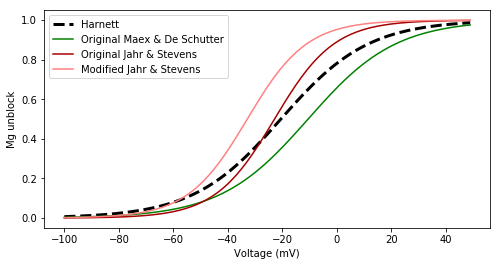

In [4]:
v = np.arange(-100, 50)
extMgConc = config['NMDA']['extMgConc']

mg_maex_orig = lambda v: 1. / (1. + 0.2801 * extMgConc * np.exp(-0.062 * (v - 10)))

mg_jahr_stevens_orig = lambda v: 1. / (1 + (extMgConc / 9.888) * np.exp(0.09137 * (2.222 - v)))

mg_harnett = lambda v: 1. / (1. + (extMgConc / 3.57) * np.exp(-0.062 * v))

plt.figure(figsize=(8,4))
plt.plot(v, mg_harnett(v), 'k--', lw=3, label='Harnett')
plt.plot(v, mg_maex_orig(v), color=[0,.5,0], label='Original Maex & De Schutter')

if config['NMDA']['model'] == 'MDS':
    alpha_vspom = config['NMDA']['alpha_vspom'] # -0.124
    v0_block    = config['NMDA']['v0_block']    # -10
    eta         = config['NMDA']['eta']         # 0.02801
    mg_maex_mod = lambda v: 1. / (1. + eta * extMgConc * np.exp(alpha_vspom * (v - v0_block)))
    plt.plot(v, mg_maex_mod(v), color=[.5,1,.5], label='Modified Maex & De Schutter')

plt.plot(v, mg_jahr_stevens_orig(v), color=[.65,0,0], label='Original Jahr & Stevens')

if config['NMDA']['model'] == 'JS':
    Kd    = config['NMDA']['Kd']    # (mM)
    gamma = config['NMDA']['gamma'] # (mV^-1)
    sh    = config['NMDA']['sh']    # (mV)
    mg_jahr_stevens_mod = lambda v: 1. / (1 + (extMgConc / Kd) * np.exp(gamma * (sh - v)))
    plt.plot(v, mg_jahr_stevens_mod(v), color=[1,.5,.5], label='Modified Jahr & Stevens')

plt.xlabel('Voltage (mV)')
plt.ylabel('Mg unblock')
plt.legend(loc='best');

### Instantiate the cell

In [5]:
cell = Cell('CA3_cell_%d' % int(np.random.uniform()*1e5), swc_file, parameters, mechanisms)
cell.instantiate(replace_axon, add_axon_if_missing, force_passive=passive, TTX=with_TTX)
section_num = config['section_num']
section = cell.morpho.apic[section_num]
Ra = section.Ra * config['Ra_neck_coeff']
print('Branch order of section {}: {}.'.format(section.name(), branch_order(section)))

One point section Import3d_Section[2] ending at line 3 has been removed
One point section Import3d_Section[1] ending at line 2 has been removed
Branch order of section CA3_cell_9821[0].apic[14]: 7.


### Instantiate the spines

In [6]:
# in the Harnett paper, the head is spherical with a diameter of 0.5 um: a cylinder
# with diameter and length equal to 0.5 has the same (outer) surface area as the sphere
head_L = config['spine']['head_L']           # [um]
head_diam = config['spine']['head_diam']     # [um]
neck_L = config['spine']['neck_L']           # [um]
neck_diam = config['spine']['neck_diam']     # [um]
spine_distance = config['spine_distance']    # [um] distance between neighboring spines
n_spines = config['n_spines']                # number of spines
L = spine_distance * (n_spines - 1)
norm_L = L / section.L

spine_loc = config['spine_loc']
start, stop = spine_loc + norm_L/2 * np.array([-1,1])
if start < 0:
    start = 0
    stop = start + norm_L
if stop > 1:
    stop = 1
    start = stop - norm_L
spines = [Spine(section, x, head_L, head_diam, neck_L, neck_diam, Ra, i) \
            for i,x in enumerate(np.linspace(start, stop, n_spines))]

for spine in spines:
    spine.instantiate()

#### Check the location of the spines in terms of distinct segments

In [7]:
segments = [section(spines[0]._sec_x)]
segments_idx = [[0]]
for i,spine in enumerate(spines[1:]):
    if section(spine._sec_x) == segments[-1]:
        segments_idx[-1].append(i+1)
    else:
        segments.append(section(spine._sec_x))
        segments_idx.append([i+1])
if len(segments_idx) == 1:
    print('All spines are connected to the same segment.')
elif len(segments_idx) == n_spines:
    print('Each spine is connected to a different segment on the dendritic branch.')
else:
    for group in segments_idx:
        if len(group) > 1:
            print('Spines {} are connected to the same segment.'.format(group))
        else:
            print('Spine {} is connected to a distinct segment.'.format(group[0]))

Spines [0, 1, 2] are connected to the same segment.
Spines [3, 4, 5, 6, 7, 8, 9] are connected to the same segment.


#### Show where the spines are located on the dendritic tree

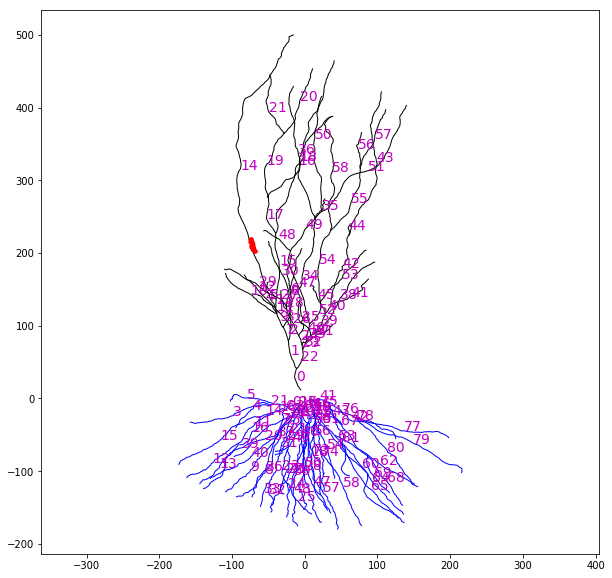

In [8]:
plt.figure(figsize=(10,10))
for sec in chain(cell.morpho.apic, cell.morpho.basal):
    if sec in cell.morpho.apic:
        color = 'k'
    else:
        color = 'b'
    lbl = sec.name().split('.')[1].split('[')[1][:-1]
    n = sec.n3d()
    sec_coords = np.zeros((n,2))
    for i in range(n):
        sec_coords[i,:] = np.array([sec.x3d(i), sec.y3d(i)])
    middle = int(n / 2)
    plt.text(sec_coords[middle,0], sec_coords[middle,1], lbl, \
             fontsize=14, color='m')
    plt.plot(sec_coords[:,0], sec_coords[:,1], color, lw=1)
for spine in spines:
    plt.plot(spine._points[:,0], spine._points[:,1], 'r.')
plt.axis('equal');

### Insert a synapse into each spine

In [9]:
MG_MODELS = {'MDS': 1, 'HRN': 2, 'JS': 3}
Mg_unblock_model = config['NMDA']['model']

E = 0        # [mV]

AMPA_taus = config['AMPA']['time_constants']
NMDA_taus = config['NMDA']['time_constants']
weights = np.array([config['AMPA']['weight'], config['NMDA']['weight']])

print('AMPA:')
print('    tau_rise = {:.3f} ms'.format(AMPA_taus['tau1']))
print('   tau_decay = {:.3f} ms'.format(AMPA_taus['tau2']))
print('NMDA:')
print('    tau_rise = {:.3f} ms'.format(NMDA_taus['tau1']))
print('   tau_decay = {:.3f} ms'.format(NMDA_taus['tau2']))

synapses = [AMPANMDAExp2Synapse(spine.head, 1, E, weights, AMPA = AMPA_taus, \
                                NMDA = NMDA_taus) for spine in spines]

for syn in synapses:
    syn.nmda_syn.mg_unblock_model = MG_MODELS[Mg_unblock_model]
    if Mg_unblock_model == 'MDS':
        syn.nmda_syn.alpha_vspom = config['NMDA']['alpha_vspom']
        syn.nmda_syn.v0_block = config['NMDA']['v0_block']
        syn.nmda_syn.eta = config['NMDA']['eta']
    elif Mg_unblock_model == 'JS':
        syn.nmda_syn.Kd = config['NMDA']['Kd']
        syn.nmda_syn.gamma = config['NMDA']['gamma']
        syn.nmda_syn.sh = config['NMDA']['sh']

if Mg_unblock_model == 'MDS':
    print('\nUsing Maex & De Schutter Mg unblock model. Modified parameters:')
    print('       alpha = {:.3f} 1/mV'.format(synapses[0].nmda_syn.alpha_vspom))
    print('    v0_block = {:.3f} mV'.format(synapses[0].nmda_syn.v0_block))
    print('         eta = {:.3f}'.format(synapses[0].nmda_syn.eta))
elif Mg_unblock_model == 'JS':
    print('\nUsing Jahr & Stevens Mg unblock model. Modified parameters:')
    print('          Kd = {:.3f} 1/mV'.format(synapses[0].nmda_syn.Kd))
    print('       gamma = {:.3f} 1/mV'.format(synapses[0].nmda_syn.gamma))
    print('          sh = {:.3f} mV'.format(synapses[0].nmda_syn.sh))
elif Mg_unblock_model == 'HRN':
    print('\nUsing Harnett Mg unblock model with default parameters.')

AMPA:
    tau_rise = 0.100 ms
   tau_decay = 1.000 ms
NMDA:
    tau_rise = 1.000 ms
   tau_decay = 50.000 ms

Using Jahr & Stevens Mg unblock model. Modified parameters:
          Kd = 9.888 1/mV
       gamma = 0.091 1/mV
          sh = -7.778 mV


#### Make the recorders

In [10]:
rec = {}
for lbl in 't','Vsoma','spike_times':
    rec[lbl] = h.Vector()
rec['t'].record(h._ref_t)
rec['Vsoma'].record(cell.morpho.soma[0](0.5)._ref_v)

apc = h.APCount(cell.morpho.soma[0](0.5))
apc.thresh = -20
apc.record(rec['spike_times'])

for i,spine in enumerate(spines):
    rec['Vdend-{}'.format(i)] = h.Vector()
    rec['Vspine-{}'.format(i)] = h.Vector()
    rec['Vdend-{}'.format(i)].record(spine._sec(spine._sec_x)._ref_v)
    rec['Vspine-{}'.format(i)].record(spine.head(0.5)._ref_v)

# these additional recorders will record the voltage from the site of the spine closest
# to the soma all the way to the soma, to see how the voltage attenuates as it travels
# towards the cell body
prop_rec = []
prop_rec_ina = []
prop_rec_ik = []
prop_rec_ica = []
prop_rec_cai = []
seg_area = []
sec = section
while sec != cell.morpho.soma[0]:
    prop_rec.append([])
    prop_rec_ina.append([])
    prop_rec_ik.append([])
    prop_rec_ica.append([])
    prop_rec_cai.append([])
    seg_area.append([])
    for seg in sec:
        prop_rec[-1].append(h.Vector())
        prop_rec[-1][-1].record(seg._ref_v)
        prop_rec_ina[-1].append(h.Vector())
        prop_rec_ina[-1][-1].record(seg._ref_ina)
        prop_rec_ik[-1].append(h.Vector())
        prop_rec_ik[-1][-1].record(seg._ref_ik)
        prop_rec_ica[-1].append(h.Vector())
        prop_rec_ica[-1][-1].record(seg._ref_ica)
        prop_rec_cai[-1].append(h.Vector())
        prop_rec_cai[-1][-1].record(seg._ref_cai)
        seg_area[-1].append(seg.area())
        if sec == section and seg == section(spines[0]._sec_x):
            break
    sec = sec.parentseg().sec
prop_rec.append([h.Vector()])
prop_rec[-1][-1].record(cell.morpho.soma[0](0.5)._ref_v)
prop_rec_ina.append([h.Vector()])
prop_rec_ina[-1][-1].record(cell.morpho.soma[0](0.5)._ref_ina)
prop_rec_ik.append([h.Vector()])
prop_rec_ik[-1][-1].record(cell.morpho.soma[0](0.5)._ref_ik)
prop_rec_ica.append([h.Vector()])
prop_rec_ica[-1][-1].record(cell.morpho.soma[0](0.5)._ref_ica)
prop_rec_cai.append([h.Vector()])
prop_rec_cai[-1][-1].record(cell.morpho.soma[0](0.5)._ref_cai)
seg_area.append([cell.morpho.soma[0](0.5).area()])

In [11]:
soma_seg = cell.morpho.soma[0](0.5)
dend_seg = spines[0]._sec(spines[0]._sec_x)
mech_rec = {
    'soma': {
        'nax':  make_mechanism_recorders(soma_seg, 'nax', 'gbar', 'ena', {'m': 3, 'h': 1}),
        'nap':  make_mechanism_recorders(soma_seg, 'nap', 'gnabar', 'ena', {'n': 3}),
        'kdr':  make_mechanism_recorders(soma_seg, 'kdr', 'gkdrbar', 'ek', {'n': 1}),
        'kap':  make_mechanism_recorders(soma_seg, 'kap', 'gkabar', 'ek', {'n': 1, 'l': 1}),
        'kmb':  make_mechanism_recorders(soma_seg, 'kmb', 'gbar', 'ek', {'m': 1}),
        'kca':  make_mechanism_recorders(soma_seg, 'kca', 'gbar', 'ek', {'m': 3}),
        'cagk': make_mechanism_recorders(soma_seg, 'cagk', 'gbar', 'ek', {'o': 1}),
        'hd':   make_mechanism_recorders(soma_seg, 'hd', 'ghdbar', -30, {'l': 1}),
        'cat':  make_mechanism_recorders(soma_seg, 'cat', 'gcatbar', 'eca', {'m': 2, 'h': 1},
                                         calcium_current=True, with_h2=False),
        'cal':  make_mechanism_recorders(soma_seg, 'cal', 'gcalbar', 'eca', {'m': 2},
                                         calcium_current=True, with_h2=True),
        'can':  make_mechanism_recorders(soma_seg, 'can', 'gcanbar', 'eca', {'m': 2, 'h': 1},
                                         calcium_current=True, with_h2=True),
    },
    'dend': {
        'nax':  make_mechanism_recorders(dend_seg, 'nax', 'gbar', 'ena', {'m': 3, 'h': 1}),
        'kdr':  make_mechanism_recorders(dend_seg, 'kdr', 'gkdrbar', 'ek', {'n': 1}),
        'kca':  make_mechanism_recorders(dend_seg, 'kca', 'gbar', 'ek', {'m': 3}),
        'kad':  make_mechanism_recorders(dend_seg, 'kad', 'gkabar', 'ek', {'n': 1, 'l': 1}),
        'cagk': make_mechanism_recorders(dend_seg, 'cagk', 'gbar', 'ek', {'o': 1}),
        'hd':   make_mechanism_recorders(dend_seg, 'hd', 'ghdbar', -30, {'l': 1}),
        'cat':  make_mechanism_recorders(dend_seg, 'cat', 'gcatbar', 'eca', {'m': 2, 'h': 1},
                                         calcium_current=True, with_h2=False),
        'cal':  make_mechanism_recorders(dend_seg, 'cal', 'gcalbar', 'eca', {'m': 2},
                                         calcium_current=True, with_h2=True),
        'can':  make_mechanism_recorders(dend_seg, 'can', 'gcanbar', 'eca', {'m': 2, 'h': 1},
                                         calcium_current=True, with_h2=True),
    }
}
try:
    mech_rec['dend']['nap'] = make_mechanism_recorders(dend_seg, 'nap', 'gnabar', 'ena', {'n': 3})
except:
    print('The cell does not have a persistent sodium current in its apical dendrite.')

The cell does not have a persistent sodium current in its apical dendrite.


#### Compute the presynaptic spike times

In [12]:
t0 = 500.
dt = 2000.

single_trial = False
with_somatic_current_injection = False

if with_somatic_current_injection:
    presyn_spike_times = [np.sort(t0 + n_spines * dt - np.arange(i) * dt) for i in range(n_spines+1, 0, -1)]
    presyn_spike_times = presyn_spike_times[:-1]
else:
    presyn_spike_times = [np.sort(t0 + (n_spines - 1) * dt - np.arange(i) * dt) for i in range(n_spines, 0, -1)]

if 'poisson_frequency' in config and False:
    F = config['poisson_frequency']
    for i in range(n_spines):
        ISI = - np.log(np.random.uniform(size=n_spines*2)) / F
        spks = np.cumsum(ISI)
        for j in range(n_spines - i):
            presyn_spike_times[j][i] += spks[j]
else:
    if 'spike_dt' in config:
        spike_dt = config['spike_dt']
    else:
        spike_dt = 0.3
    for i in range(n_spines):
        for j in range(len(presyn_spike_times[i])):
            presyn_spike_times[i][j] += i * spike_dt

if single_trial:
    presyn_spike_times = [np.array([spks[-1] - presyn_spike_times[0][-1] + t0]) for spks in presyn_spike_times]
    
for syn, spks in zip(synapses, presyn_spike_times):
    syn.set_presynaptic_spike_times(spks)
    
if with_somatic_current_injection:
    stim['soma'].amp = 0.06
    stim['soma'].dur = 100
    stim['soma'].delay = presyn_spike_times[0][-1]

In [13]:
presyn_spike_times

[array([  500.,  2500.,  4500.,  6500.,  8500., 10500., 12500., 14500.,
        16500., 18500.]),
 array([ 2501.,  4501.,  6501.,  8501., 10501., 12501., 14501., 16501.,
        18501.]),
 array([ 4502.,  6502.,  8502., 10502., 12502., 14502., 16502., 18502.]),
 array([ 6503.,  8503., 10503., 12503., 14503., 16503., 18503.]),
 array([ 8504., 10504., 12504., 14504., 16504., 18504.]),
 array([10505., 12505., 14505., 16505., 18505.]),
 array([12506., 14506., 16506., 18506.]),
 array([14507., 16507., 18507.]),
 array([16508., 18508.]),
 array([18509.])]

#### Run the simulation

In [14]:
h.cvode_active(1)
h.tstop = presyn_spike_times[0][-1] + dt
if with_somatic_current_injection:
    h.tstop += dt
h.run();

#### Get the data from the recorders

In [15]:
t = np.array(rec['t'])
Vspine = np.array([np.array(rec['Vspine-{}'.format(i)]) for i in range(n_spines)])
Vdend = np.array([np.array(rec['Vdend-{}'.format(i)]) for i in range(n_spines)])
Vsoma = np.array(rec['Vsoma'])

prop_V = [[np.array(v) for v in grp] for grp in prop_rec]
prop_INa = [[np.array(v) for v in grp] for grp in prop_rec_ina]
prop_IK = [[np.array(v) for v in grp] for grp in prop_rec_ik]
prop_ICa = [[np.array(v) for v in grp] for grp in prop_rec_ica]
prop_Cai = [[np.array(v) for v in grp] for grp in prop_rec_cai]

### spike times
spks = np.array(rec['spike_times'])
spike_times = [spks[(spks > spk) & (spks < spk + 200)] for spk in presyn_spike_times[0]]
N_spikes = np.array(list(map(len, spike_times)))
print(N_spikes)

[0 0 0 0 1 1 1 1 1 1]


1. the somatic voltage is in prop_V[-1][0]
1. the membrane voltage of the dendrite connected to the first spine is in prop_V[0][-1]

In [16]:
np.all(prop_V[0][-1] == Vdend[0])

True

In [17]:
np.all(prop_V[-1][0] == Vsoma)

True

In [18]:
currents = {}
for loc in mech_rec:
    currents[loc] = {}
    for key,value in mech_rec[loc].items():
        currents[loc][key] = compute_current(value)

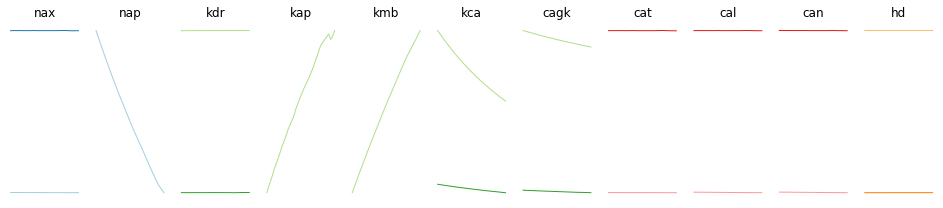

In [19]:
current_names = 'nax', 'nap', 'kdr', 'kap', 'kmb', 'kca', 'cagk', 'cat', 'cal', 'can', 'hd'
n_currents = len(current_names)
fig,ax = plt.subplots(1, n_currents, figsize=(1.2 * n_currents, 3))
xlim = [13000, 13050]
idx = (t > xlim[0]) & (t < xlim[1])
cmap = plt.get_cmap('Paired')
for i,name in enumerate(current_names):
    if 'na' in name:
        jdx = 0
    elif 'k' in name:
        jdx = 1
    elif 'ca' in name:
        jdx = 2
    else:
        jdx = 3
    ax[i].plot(t[idx], currents['soma'][name][idx], color=cmap(jdx * 2), lw=1)
    if name in currents['dend']:
        ax[i].plot(t[idx], currents['dend'][name][idx], color=cmap(jdx * 2 + 1), lw=1)
    ax[i].set_title(name)

for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    a.axis('off')

fig.tight_layout()

#### Save the traces containing spikes to an Excel spreadsheet

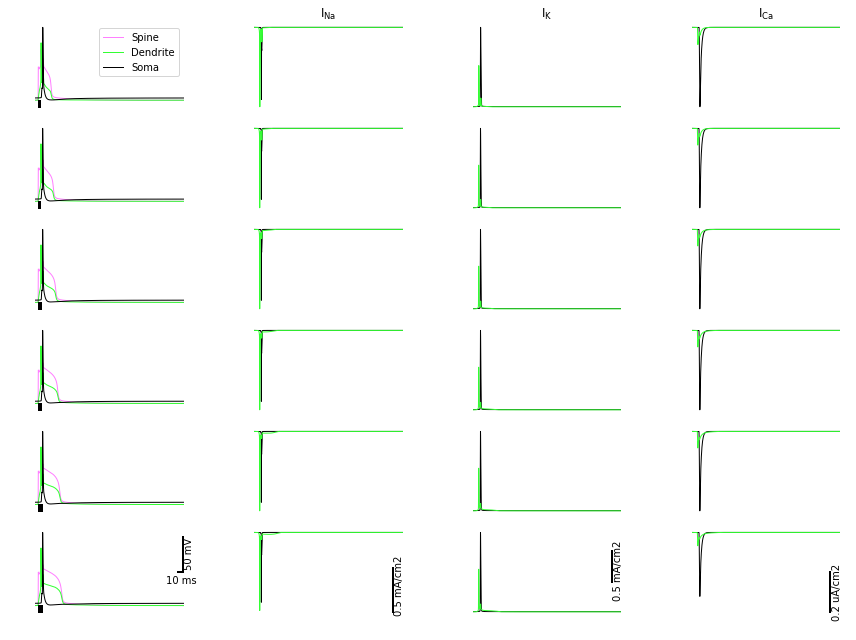

In [20]:
window = [100,500]
rows = np.sum(N_spikes != 0)
cols = 4
xlim = [-5, 300]
fig,ax = plt.subplots(rows, 4, figsize=(cols * 3, rows * 1.5), sharex=True)

current_names = 'nax', 'nap', 'kdr', 'kap', 'kmb', 'kca', 'cagk', 'cat', 'cal', 'can', 'hd'
n_currents = len(current_names)

with pd.ExcelWriter(f'synaptic_inputs_active_{cell_type}_{individual}.xlsx') as writer:
    for i,idx in enumerate(np.where(N_spikes > 0)[0]):
        t0 = presyn_spike_times[0][idx]
        jdx, = np.where((t > t0 - window[0]) & (t < t0 + window[1]))
        data = {}
        data['Time'] = t[jdx] - t0
        data['V_soma'] = Vsoma[jdx]
        for j in range(n_spines):
            data[f'V_dend_{j+1}'] = Vdend[j][jdx]
            data[f'V_spine_{j+1}'] = Vspine[j][jdx]
        data['INa_soma'] = prop_INa[-1][0][jdx]
        data['IK_soma']  = prop_IK[-1][0][jdx]
        data['ICa_soma'] = prop_ICa[-1][0][jdx]
        data['INa_dend'] = prop_INa[0][-1][jdx]
        data['IK_dend']  = prop_IK[0][-1][jdx]
        data['ICa_dend'] = prop_ICa[0][-1][jdx]
        for loc in 'soma','dend':
            for j,name in enumerate(current_names):
                if name in currents[loc]:
                    data[f'I{name}_{loc}'] = currents[loc][name][jdx]
#         data['INa_soma (mA/cm2)'] = prop_INa[-1][0][jdx]
#         data['IK_soma (mA/cm2)'] = prop_IK[-1][0][jdx]
#         data['ICa_soma (mA/cm2)'] = prop_ICa[-1][0][jdx]
#         data['INa_soma (nA)'] = prop_INa[-1][0][jdx] * seg_area[-1][0]
#         data['IK_soma (nA)'] = prop_IK[-1][0][jdx] * seg_area[-1][0]
#         data['ICa_soma (nA)'] = prop_ICa[-1][0][jdx] * seg_area[-1][0]
#         data['INa_dend (mA/cm2)'] = prop_INa[0][-1][jdx]
#         data['IK_dend (mA/cm2)'] = prop_IK[0][-1][jdx]
#         data['ICa_dend (mA/cm2)'] = prop_ICa[0][-1][jdx]
#         data['INa_dend (nA)'] = prop_INa[0][-1][jdx] * seg_area[0][-1]
#         data['IK_dend (nA)'] = prop_IK[0][-1][jdx] * seg_area[0][-1]
#         data['ICa_dend (nA)'] = prop_ICa[0][-1][jdx] * seg_area[0][-1]
        df = pd.DataFrame(data)
        df.to_excel(writer, sheet_name=f'N_pre={idx+1}')
        ax[i,0].plot(t[jdx] - t0, Vspine[0][jdx], color=[1,.5,1], lw=1, label='Spine')
        ax[i,0].plot(t[jdx] - t0, Vdend[0][jdx], color=[.2,1,.2], lw=1, label='Dendrite')
        ax[i,0].plot(t[jdx] - t0, Vsoma[jdx], 'k', lw=1, label='Soma')
        ax[i,1].plot(t[jdx] - t0, prop_INa[-1][0][jdx], 'k', lw=1)
        ax[i,2].plot(t[jdx] - t0, prop_IK[-1][0][jdx], 'k', lw=1)
        ax[i,3].plot(t[jdx] - t0, prop_ICa[-1][0][jdx], 'k', lw=1)
        ax[i,1].plot(t[jdx] - t0, prop_INa[0][-1][jdx], color=[.2,1,.2], lw=1)
        ax[i,2].plot(t[jdx] - t0, prop_IK[0][-1][jdx], color=[.2,1,.2], lw=1)
        ax[i,3].plot(t[jdx] - t0, prop_ICa[0][-1][jdx], color=[.2,1,.2], lw=1)
        V0 = Vsoma[jdx].min()
        dx = 10
        ax[i,0].plot([0,0], V0 + np.array([-dx, 0]), 'k', lw=1)
        for j in range(1, n_spines):
            k, = np.where(presyn_spike_times[j] > t0)
            if len(k):
                ax[i,0].plot(presyn_spike_times[j][k[0]] - t0 + np.zeros(2), V0 + np.array([-dx, 0]), 'k', lw=1)
        for j in range(4):
            ax[i,j].set_xlim(xlim)
            ax[i,j].axis('off')
    ax[0,0].legend(loc='upper right')
    ax[-1,0].plot(xlim[1] - np.array([11,1]), -20 + np.zeros(2), 'k', lw=2)
    ax[-1,0].text(xlim[1] - 5, -25, '10 ms', horizontalalignment='center', verticalalignment='top')

    ax[-1,0].plot(xlim[1] - 1 + np.zeros(2), [-20, 30], 'k', lw=2)
    ax[-1,0].text(xlim[1] + 1, 7.5, '50 mV', horizontalalignment='left', verticalalignment='center', rotation=90)

    ax[-1,1].plot(xlim[1] - 20 + np.zeros(2), [-0.9, -0.4], 'k', lw=2)
    ax[-1,1].text(xlim[1] - 17, -0.6, '0.5 mA/cm2', horizontalalignment='left',
                  verticalalignment='center', rotation=90)

    ax[-1,2].plot(xlim[1] - 20 + np.zeros(2), [0.5, 1], 'k', lw=2)
    ax[-1,2].text(xlim[1] - 17, 0.7, '0.5 mA/cm2', horizontalalignment='left',
                  verticalalignment='center', rotation=90)

    ax[-1,3].plot(xlim[1] - 20 + np.zeros(2), [-0.0004, -0.0002], 'k', lw=2)
    ax[-1,3].text(xlim[1] - 17, -0.0003, '0.2 uA/cm2', horizontalalignment='left',
                  verticalalignment='center', rotation=90)

    ax[0,1].set_title(r'$\mathrm{I_{Na}}$')
    ax[0,2].set_title(r'$\mathrm{I_{K}}$')
    ax[0,3].set_title(r'$\mathrm{I_{Ca}}$')
    fig.tight_layout()
    fig.savefig(f'synaptic_inputs_active_{cell_type}_{individual}.pdf')

#### Plot the results

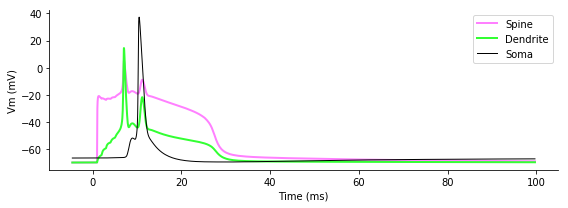

In [21]:
first = np.where(N_spikes > 0)[0][0]
window = [5,100]
t0 = presyn_spike_times[0][first]
idx, = np.where((t > t0 - window[0]) & (t < t0 + window[1]))
fig,ax = plt.subplots(1, 1, figsize=(8,3))
ax.plot(t[idx] - t0, Vspine[0][idx], color=[1,.5,1], linewidth=2, label='Spine')
ax.plot(t[idx] - t0, Vdend[0][idx], color=[.2,1,.2], linewidth=2, label='Dendrite')
ax.plot(t[idx] - t0, Vsoma[idx], 'k', linewidth=1, label='Soma')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Vm (mV)')
ax.legend(loc='upper right')
for side in ('right','top'):
    ax.spines[side].set_visible(False)
fig.tight_layout();

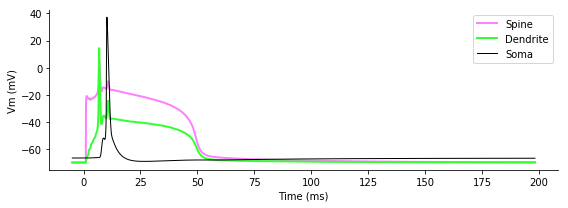

In [22]:
last = np.where(N_spikes > 0)[0][-1]
window = [5,200]
t0 = presyn_spike_times[0][last]
idx, = np.where((t > t0 - window[0]) & (t < t0 + window[1]))
fig,ax = plt.subplots(1, 1, figsize=(8,3))
ax.plot(t[idx] - t0, Vspine[0][idx], color=[1,.5,1], linewidth=2, label='Spine')
ax.plot(t[idx] - t0, Vdend[0][idx], color=[.2,1,.2], linewidth=2, label='Dendrite')
ax.plot(t[idx] - t0, Vsoma[idx], 'k', linewidth=1, label='Soma')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Vm (mV)')
ax.legend(loc='upper right')
for side in ('right','top'):
    ax.spines[side].set_visible(False)
fig.tight_layout();

#### Plot the results
Here we see how membrane voltage, internal calcium concentration and ionic currents evolve as we move towards the soma. The three bottom panel display current densities on the left and actual current values on the right.

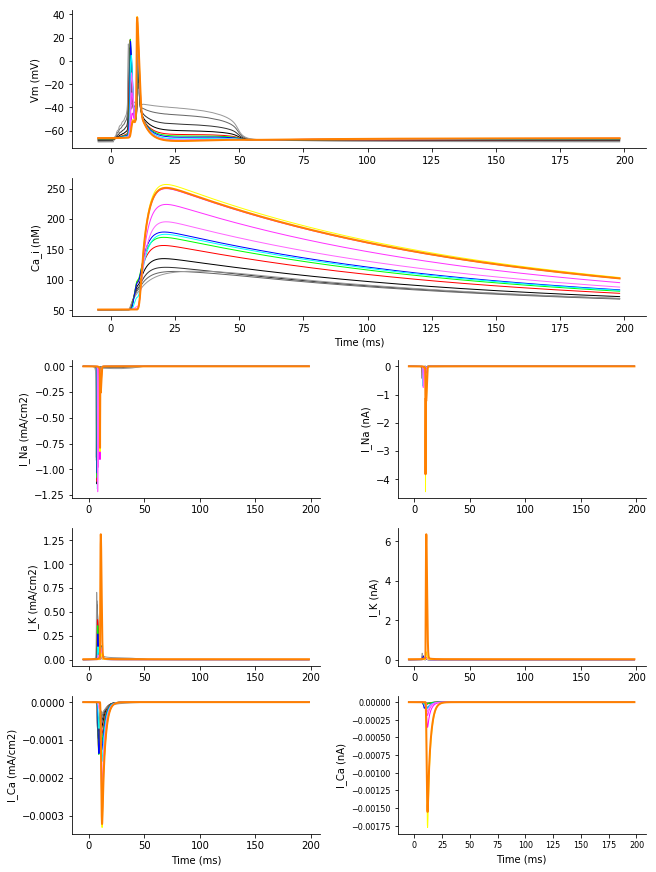

In [23]:
n_rec = len([0 for grp in prop_rec for v in grp])
colors = [[0,0,0], [1,0,0], [0,1,0], [0,0,1], [0,1,1], [1,0,1], [1,1,0], [1,.5,0]]
cmap = plt.get_cmap('hsv', len(prop_V))
fig = plt.figure(constrained_layout=True, figsize=(9,12))
gs = fig.add_gridspec(5, 2)
ax_V = fig.add_subplot(gs[0,:])
ax_Ca = fig.add_subplot(gs[1,:])
ax = [[fig.add_subplot(gs[i,j]) for j in (0,1)] for i in (2,3,4)]
for i in range(len(prop_V)):
    base_col = colors[i]
    if i == len(prop_V) - 1:
        lw = 2
    else:
        lw = 1
    for j in range(len(prop_INa[i])):
        col = np.min([[1,1,1], base_col + j * 0.2 * np.ones(3)], axis=0)
        ax_V.plot(t[idx] - t0, prop_V[i][j][idx], color=col, linewidth=lw)
        ax_Ca.plot(t[idx] - t0, prop_Cai[i][j][idx]*1e6, color=col, linewidth=lw)
        ax[0][0].plot(t[idx] - t0, prop_INa[i][j][idx], color=col, linewidth=lw)
        ax[1][0].plot(t[idx] - t0, prop_IK[i][j][idx], color=col, linewidth=lw)
        ax[2][0].plot(t[idx] - t0, prop_ICa[i][j][idx], color=col, linewidth=lw)
        ax[0][1].plot(t[idx] - t0, prop_INa[i][j][idx] * seg_area[i][j] * 1e-2, color=col, linewidth=lw)
        ax[1][1].plot(t[idx] - t0, prop_IK[i][j][idx] * seg_area[i][j] * 1e-2, color=col, linewidth=lw)
        ax[2][1].plot(t[idx] - t0, prop_ICa[i][j][idx] * seg_area[i][j] * 1e-2, color=col, linewidth=lw)
for side in ('right','top'):
    for i in range(3):
        for j in range(2):
            ax[i][j].spines[side].set_visible(False)
    ax_V.spines[side].set_visible(False)
    ax_Ca.spines[side].set_visible(False)
ax_Ca.set_xlabel('Time (ms)')
ax_V.set_ylabel('Vm (mV)')
ax_Ca.set_ylabel('Ca_i (nM)')
ax[0][0].set_ylabel('I_Na (mA/cm2)')
ax[1][0].set_ylabel('I_K (mA/cm2)')
ax[2][0].set_ylabel('I_Ca (mA/cm2)')
ax[0][1].set_ylabel('I_Na (nA)')
ax[1][1].set_ylabel('I_K (nA)')
ax[2][1].set_ylabel('I_Ca (nA)')
ax[2][0].set_xlabel('Time (ms)')
ax[2][1].set_xlabel('Time (ms)')
plt.tick_params(labelsize=8)

#### Save the data